In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
#%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Color import *

# Matplotlib font configuration
from MatplotlibFonts import *

# Change the font size
rcParams.update({"font.size": 14})

In [22]:
RESULT_DIR='../benchmarks/results-O3'

In [23]:
# Benchmarks in order
Benchmarks = [
    'coremark',
    'sha',
    'crc',
    'aes',
    'dijkstra',
    'picojpeg'
]

# Configurations in order
Configurations = [
    'opt-ratchet',
    'opt-baseline',
    'opt-writebuf',
    'opt-loop',
    'opt-all'
]
from BenchmarkConfiguration import *

In [24]:
# Load the benchmarks
def load_benchmark(bench):
    file = RESULT_DIR + '/raw/' + bench + '-results-table-raw.csv'
    return pd.read_csv(file).set_index('Configuration')

df = {}
for bench in Benchmarks:
    df[bench] = load_benchmark(bench)

In [25]:
# Order per group: Ratchet, Ratchet+Noelle, Write Buffering, Loop Clustering, Opt-all
group_size = len(Configurations)
group_count = len(Benchmarks)
print('Group count:', group_count)
print('Group size:', group_size)

Group count: 6
Group size: 5


In [26]:
df['sha'] = df['sha'].reindex(ConfigurationNameMap)
df['sha']

,Cycles,Checkpoints,IR-checkpoints,Call-checkpoints,Pop-checkpoints,Spill-checkpoints,Execution,Execution-baseline,Overhead-baseline-%,Overhead-ratchet-%
Configuration,,,,,,,,,,
opt-ratchet,51065737,599751,589621,138,9986,5,3.560616,2.344926,393.91,0.00
opt-baseline,21777118,131991,121861,138,9986,5,1.518434,1.000000,0.00,-79.75
opt-writebuf,21743094,131991,121861,138,9986,5,1.516062,0.998438,-0.46,-79.85
opt-loop,19077982,78467,53643,9921,10025,4877,1.330234,0.876056,-36.30,-87.10
opt-all,18736936,73595,53643,5049,10025,4877,1.306454,0.860396,-40.89,-88.03


In [27]:
dfa = pd.DataFrame()
for bench in Benchmarks:
    dfa[bench] = df[bench].reindex(ConfigurationNameMap)['Execution']
    
dfa.rename(index=ConfigurationNameMap, inplace=True)
dfa

,coremark,sha,crc,aes,dijkstra,picojpeg
Configuration,,,,,,
Ratchet,3.376760,3.560616,3.616687,4.392722,1.072110,5.369932
Improved Ratchet,3.216476,1.518434,3.616687,2.928826,1.025875,5.267627
Write Clustering,3.187072,1.516062,3.619946,2.680706,1.024480,4.499364
Loop Clustering,2.636560,1.330234,3.616590,2.080131,1.025015,5.068496
Complete System,2.526472,1.306454,3.619946,1.845636,1.050558,4.416431


In [28]:
mean_ratchet = dfa.T[ConfigurationNameMap['opt-ratchet']].mean()
mean_baseline = dfa.T[ConfigurationNameMap['opt-baseline']].mean()
mean_opt_all = dfa.T[ConfigurationNameMap['opt-all']].mean()

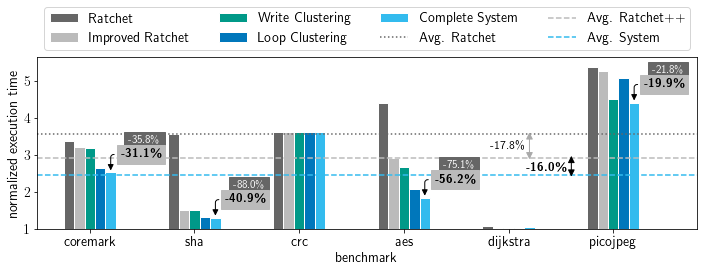

In [29]:
bars = dfa.T.plot(kind='bar', ylim=(1,None), figsize=(10,4), color=[ConfigurationColorMap[c] for c in Configurations], edgecolor='white', linewidth=1)
plt.xticks(rotation=0)

handles, labels = bars.get_legend_handles_labels()

# Average for Ratchet and Opt-All
mean_ratchet_line = plt.axhline(y = mean_ratchet, color = ConfigurationColorMap['opt-ratchet'], 
                                linestyle = ':', label='Avg. Ratchet')
mean_baseline_line = plt.axhline(y = mean_baseline, color = ConfigurationColorMap['opt-baseline'],
                                 linestyle = '--', label='Avg. Ratchet++')
mean_opt_all_line = plt.axhline(y = mean_opt_all, color = ConfigurationColorMap['opt-all'],
                                linestyle = '--',label='Avg. System')

# Manually place the average lines at the end of the legend
handles.extend([mean_ratchet_line, mean_baseline_line, mean_opt_all_line])
bars.legend(handles=handles, bbox_to_anchor=(0, 1.0, 1, 0), loc="lower left", mode='expand', ncol=4)

# Iterate through the benchmarks (in order)
for idx, bench in enumerate(Benchmarks):
    # Skip some benchmark(s)
    skip = ['dijkstra', 'crc']
    if bench in skip:
        continue
        
    overhead_ratchet_perc = df[bench]['Overhead-ratchet-%']['opt-all']
    overhead_baseline_perc = df[bench]['Overhead-baseline-%']['opt-all']
    execution_value = df[bench]['Execution']['opt-all']
    
    def add_bar_label(text, text_loc, textcolor='black', facecolor='white', edgecolor='black', fontsize=11, draw_arrow=False):
        if draw_arrow == True:
            arrowprops = dict(arrowstyle='-|>', fc='black', connectionstyle='angle,angleA=0,angleB=90,rad=3')
        else:
            arrowprops = None
        
        plt.annotate(text, xy=(idx+0.2, execution_value), xytext=text_loc,
            color=textcolor,
            xycoords=('data'), textcoords='offset points', fontsize=fontsize,
            horizontalalignment='right', verticalalignment='center',
            bbox=dict(facecolor=facecolor, linewidth='1', edgecolor=edgecolor),
            arrowprops=arrowprops,
        )
        
    add_bar_label('{:02.1f}\%'.format(overhead_ratchet_perc),
                  text_loc=(50,32),
                  fontsize=11,
                  textcolor='white',
                  edgecolor=ConfigurationColorMap['opt-ratchet'],
                  facecolor=ConfigurationColorMap['opt-ratchet'],
                  draw_arrow=False)
    add_bar_label('\\textbf{'+'{:02.1f}\%'.format(overhead_baseline_perc)+'}',
                  text_loc=(50, 18),
                  fontsize=12,
                  edgecolor=ConfigurationColorMap['opt-baseline'],
                  facecolor=ConfigurationColorMap['opt-baseline'],
                  draw_arrow=True)
    

# Annotate the average lines
plt.annotate('', xy=(4.6, mean_opt_all-0.1), xytext=(4.6,mean_baseline+0.1),
             arrowprops=dict(arrowstyle='<|-|>', fc='black'))
reduction_perc = (mean_baseline-mean_opt_all)/mean_baseline * 100
plt.annotate('\\textbf{'+'-{:02.1f}\%'.format(reduction_perc)+'}', xy=(4.6, mean_opt_all+(mean_baseline-mean_opt_all)/2), 
             xytext=(-5,-2), textcoords='offset points',
             fontsize=12,
             horizontalalignment='right', verticalalignment='center')


plt.annotate('', xy=(4.2, mean_baseline-0.1), xytext=(4.2,mean_ratchet+0.1),
             arrowprops=dict(arrowstyle='<|-|>', fc='darkgrey', edgecolor='darkgrey'))
reduction_perc = (mean_ratchet-mean_baseline)/mean_ratchet * 100
plt.annotate('-{:02.1f}\%'.format(reduction_perc), xy=(4.2, mean_baseline+(mean_ratchet-mean_baseline)/2), 
             xytext=(-5,0), textcoords='offset points',
             fontsize=12,
             horizontalalignment='right', verticalalignment='center')

#plt.subplots_adjust(right=1.3)
plt.xlim(None, len(Benchmarks)-1+0.8)

# Set the axis
plt.xlabel('benchmark')
plt.ylabel('normalized execution time')

# Show the plot
plt.tight_layout()
plt.show()


In [19]:
# Save the figure
fig = bars.get_figure()
fig.savefig('plots/benchmark-comparison.pdf')

In [20]:


# Create the checkpoint figure



In [21]:
for bench in Benchmarks:
    #cps = df[bench]['Checkpoints']['opt-baseline']-1
    dfb = df[bench]
    cps = (dfb['IR-checkpoints']+dfb['Call-checkpoints']+dfb['Pop-checkpoints']+dfb['Spill-checkpoints'])['opt-baseline']
    dfb['IR-checkpoints-%'] =  dfb['IR-checkpoints']/cps*100
    dfb['Call-checkpoints-%'] =  dfb['Call-checkpoints']/cps*100
    dfb['Pop-checkpoints-%'] =  dfb['Pop-checkpoints']/cps*100
    dfb['Spill-checkpoints-%'] =  dfb['Spill-checkpoints']/cps*100

df['coremark']

,Cycles,Checkpoints,IR-checkpoints,Call-checkpoints,Pop-checkpoints,Spill-checkpoints,Execution,Execution-baseline,Overhead-baseline-%,Overhead-ratchet-%,IR-checkpoints-%,Call-checkpoints-%,Pop-checkpoints-%,Spill-checkpoints-%
Configuration,,,,,,,,,,,,,,
uninstrumented,2435819,0,0,0,0,0,1.000000,0.304274,-100.00,-100.00,0.000000,0.000000,0.000000,0.000000
opt-ratchet,8343697,91961,68761,7232,10184,5783,3.425417,1.042264,6.07,0.00,79.246957,8.334870,11.737046,6.664900
opt-baseline,8005355,86769,62292,7232,10184,7060,3.286515,1.000000,0.00,-5.73,71.791444,8.334870,11.737046,8.136640
opt-writebuf,8055494,87465,62292,7232,10184,7756,3.307099,1.006263,0.90,-4.88,71.791444,8.334870,11.737046,8.938779
opt-loop,6487590,62692,35772,7230,10184,9505,2.663412,0.810406,-27.25,-31.42,41.227181,8.332565,11.737046,10.954499
opt-all,6468745,62447,35772,7234,10184,9256,2.655676,0.808052,-27.59,-31.74,41.227181,8.337175,11.737046,10.667527
loop-unroll-6,6447737,62066,36792,7234,10184,7855,2.647051,0.805428,-27.97,-32.09,42.402729,8.337175,11.737046,9.052877
loop-unroll-4,6610367,64840,39852,7233,10184,7570,2.713817,0.825743,-25.05,-29.34,45.929375,8.336022,11.737046,8.724415
opt-loop-unroll-only,7777430,84240,62292,7232,10184,4531,3.192942,0.971528,-4.09,-9.58,71.791444,8.334870,11.737046,5.221971


In [14]:
dfc = {}
plot = ['IR-checkpoints-%', 'Spill-checkpoints-%', 'Call-checkpoints-%', 'Pop-checkpoints-%']

for p in plot:
    dfc[p] = pd.DataFrame()
    for bench in Benchmarks:
        dfc[p][bench] = df[bench].reindex(Configurations)[p]
    
    dfc[p].rename(index=ConfigurationNameMap, inplace=True)
    dfc[p].drop('Ratchet', inplace=True)
    

dfc[plot[1]]

,coremark,sha,crc,aes,dijkstra,picojpeg
Configuration,,,,,,
Improved Ratchet,8.136640,14.771574,0.725514,8.276947,0.310039,0.097306
Write Clustering,9.353679,14.771574,0.725514,9.504327,0.310039,0.226817
Loop Clustering,11.231099,18.462762,0.725514,16.097561,0.310039,0.614589
Complete System,10.114328,0.000000,0.725514,10.369788,0.310039,0.744100


In [15]:
df['sha']

,Cycles,Checkpoints,IR-checkpoints,Call-checkpoints,Pop-checkpoints,Spill-checkpoints,Execution,Execution-baseline,Overhead-baseline-%,Overhead-ratchet-%,IR-checkpoints-%,Call-checkpoints-%,Pop-checkpoints-%,Spill-checkpoints-%
Configuration,,,,,,,,,,,,,,
opt-ratchet,53312108.0,619243.0,570129,138,9986,38989,3.650265,2.361427,385.59,0.00,431.948632,0.104553,7.565725,29.539359
opt-baseline,22576226.0,131991.0,102369,138,9986,19497,1.545788,1.000000,0.00,-79.41,77.558148,0.104553,7.565725,14.771574
opt-writebuf,23765316.0,151483.0,121861,138,9986,19497,1.627204,1.052670,14.92,-76.33,92.325934,0.104553,7.565725,14.771574
opt-loop,21109950.0,97959.0,53643,9921,10025,24369,1.445392,0.935052,-18.39,-83.19,40.641715,7.516479,7.595272,18.462762
opt-all,NaN,NaN,0,0,0,0,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000


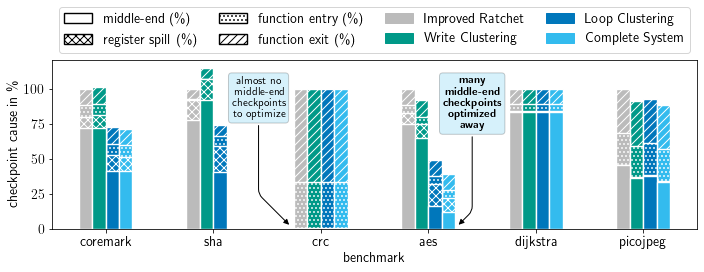

In [16]:
from matplotlib.patches import Patch

ax = plt.figure(figsize=(10,4)).add_subplot(111)

cc = [ConfigurationColorMap[c] for c in Configurations[1:]]
labels = [ConfigurationNameMap[c] for c in Configurations[1:]]
width = 0.5
lw = 1.4

def patchwork(ax, hatch):
    for bar in ax.patches:
        if bar.get_hatch() == None: 
            bar.set_hatch(hatch)
            
def plot_bar(N):
    D = dfc[plot[0]]
    for n in range(1, N+1):
        D = D + dfc[plot[n]]
        
    D.T.plot(kind='bar', ax=ax, color=cc, width=width, edgecolor='white', legend=None, linewidth=lw)
    patchwork(ax, hatch_map[plot[N]])

hatch_map = {
    'IR-checkpoints-%': '',
    'Spill-checkpoints-%': 'xxx',
    'Call-checkpoints-%': '...',
    'Pop-checkpoints-%': '///'
}

# Plot the overlapping bars
plot_bar(3)
plot_bar(2)
plot_bar(1)
plot_bar(0)

# Plot the description of the crc benchmark
props = dict(boxstyle='round', facecolor=Color['cyan'], alpha=0.2)
text =  'almost no\nmiddle-end\ncheckpoints\nto optimize'
plt.annotate(text, xy=(1.72, 2), xytext=(-32, 150),
        transform=ax.transAxes, textcoords='offset points', fontsize=11,
        horizontalalignment='center', verticalalignment='top',
        bbox=props,
        arrowprops=dict(arrowstyle='-|>', fc='black', connectionstyle='angle,angleA=90,angleB=-45,rad=5'),
)
props = dict(boxstyle='round', facecolor=Color['cyan'], alpha=0.2)
text =  '\\textbf{many}\n\\textbf{middle-end}\n\\textbf{checkpoints}\n\\textbf{optimized}\n\\textbf{away}'
plt.annotate(text, xy=(3.27, 2), xytext=(15, 150),
        transform=ax.transAxes, textcoords='offset points', fontsize=11,
        horizontalalignment='center', verticalalignment='top',
        bbox=props,
        arrowprops=dict(arrowstyle='-|>', fc='black', connectionstyle='angle,angleA=90,angleB=45,rad=5'),
)

plt.xticks(rotation=0)
#ax.legend(bbox_to_anchor=(0, 1.0, 1, 0), loc="lower left", mode='expand', ncol=4)

handles = []
handles.append(Patch(label='middle-end (\%)', hatch=hatch_map['IR-checkpoints-%'],
                     facecolor='none', edgecolor='black', linewidth=lw))
handles.append(Patch(label='register spill (\%)', hatch=hatch_map['Spill-checkpoints-%'],
                     facecolor='none', edgecolor='black', linewidth=lw))
handles.append(Patch(label='function entry (\%)', hatch=hatch_map['Call-checkpoints-%'],
                     facecolor='none', edgecolor='black', linewidth=lw))
handles.append(Patch(label='function exit (\%)', hatch=hatch_map['Pop-checkpoints-%'],
                     facecolor='none', edgecolor='black', linewidth=lw))

for idx, l in enumerate(labels):
    handles.append(Patch(label=l, color=cc[idx]))

ax.legend(handles=handles, bbox_to_anchor=(0, 1.0, 1, 0), loc="lower left", mode='expand', ncol=4)

plt.xlabel('benchmark')
plt.ylabel(r'checkpoint cause in \%')

plt.tight_layout()
plt.show()

In [17]:
# Save the figure
fig = ax.get_figure()
fig.savefig('plots/benchmark-checkpoint-distribution.pdf')

In [18]:




# TESTING





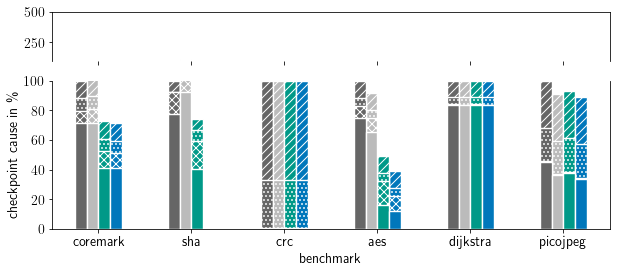

In [19]:
from matplotlib.patches import Patch

#ax = plt.figure(figsize=(10,4)).add_subplot(111)
fig, (axtop, ax) = plt.subplots(2, 1, sharex=True, figsize=(10,4), gridspec_kw={'height_ratios': [1, 3]})
plt.subplots_adjust(hspace=0.2)

ax.set_ylim([0,100])
axtop.set_ylim([100,500])

ax.spines['top'].set_visible(False)
axtop.spines['bottom'].set_visible(False)

cc = [ConfigurationColorMap[c] for c in Configurations[0:]]
labels = [ConfigurationNameMap[c] for c in Configurations[0:]]
width = 0.5
lw = 1.4

def patchwork(ax, hatch):
    for bar in ax.patches:
        if bar.get_hatch() == None: 
            bar.set_hatch(hatch)
            
def plot_bar(N):
    D = dfc[plot[0]]
    for n in range(1, N+1):
        D = D + dfc[plot[n]]
        
    D.T.plot(kind='bar', ax=ax, color=cc, width=width, edgecolor='white', legend=None, linewidth=lw)
    patchwork(ax, hatch_map[plot[N]])
    
    D.T.plot(kind='bar', ax=axtop, color=cc, width=width, edgecolor='white', legend=None, linewidth=lw)
    patchwork(axtop, hatch_map[plot[N]])

hatch_map = {
    'IR-checkpoints-%': '',
    'Spill-checkpoints-%': 'xxx',
    'Call-checkpoints-%': '...',
    'Pop-checkpoints-%': '///'
}

# Plot the overlapping bars
plot_bar(3)
plot_bar(2)
plot_bar(1)
plot_bar(0)

plt.xticks(rotation=0)
#ax.legend(bbox_to_anchor=(0, 1.0, 1, 0), loc="lower left", mode='expand', ncol=4)

handles = []
handles.append(Patch(label='middle-end (\%)', hatch=hatch_map['IR-checkpoints-%'],
                     facecolor='none', edgecolor='black', linewidth=lw))
handles.append(Patch(label='register spill (\%)', hatch=hatch_map['Spill-checkpoints-%'],
                     facecolor='none', edgecolor='black', linewidth=lw))
handles.append(Patch(label='function entry (\%)', hatch=hatch_map['Call-checkpoints-%'],
                     facecolor='none', edgecolor='black', linewidth=lw))
handles.append(Patch(label='function exit (\%)', hatch=hatch_map['Pop-checkpoints-%'],
                     facecolor='none', edgecolor='black', linewidth=lw))

for idx, l in enumerate(labels):
    handles.append(Patch(label=l, color=cc[idx]))

#ax.legend(handles=handles, bbox_to_anchor=(0, 1.0, 1, 0), loc="lower left", mode='expand', ncol=4)

plt.xlabel('benchmark')
plt.ylabel(r'checkpoint cause in \%')

#plt.tight_layout()
plt.show()